<a href="https://colab.research.google.com/github/BenWilliams2109/introduction-to-machine-learning/blob/main/comp88_lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 8



## Introduction

In this final lab session, you'll generate and fit data from two latent variable models: **Gaussian Mixture Models** (GMMs) and **Hidden Markov Models** (HMMs). Both kinds of model can be fitted in the unsupervised setting using **Expectation Maximisation** approaches, in a similar fashion to the $k$-Means algorithm from last week.

<!-- Examples of the kinds of plots that will be produced by your finished code are shown below. Plotting code is provided, so your plots should look pretty similar, though there is also some randomisation.

![example of completed plots](https://comp0088.github.io/assets/colab/week_7.jpg) -->


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them. In addition, we'll import a couple of useful statistics functions from SciPy, and also install and import an external library for Hidden Markov Models.

In [1]:
import numpy as np
import numpy.random

import matplotlib
import matplotlib.pyplot as plt

from time import perf_counter

%matplotlib inline

from scipy.stats import multivariate_normal as mvn, norm

%pip install hmmlearn
import hmmlearn.hmm as hmm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 2.6 MB/s eta 0:00:00


As ever, we'll also fetch shared code from the COMP0088 GitHub:

In [2]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 7 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 10.81 KiB | 1.54 MiB/s, done.
Resolving deltas: 100% (1/1), done.


And, one last time, set up some globals for later use.


In [99]:
# the usual random number generator
shared_rng = numpy.random.default_rng()

LIMITS = (-10, 10)
NUM_GAUSSIANS = 4
NUM_SAMPLES = 100

DARK = [plt.cm.tab20.colors[2 * ii] for ii in range(10)]
LIGHT = [plt.cm.tab20.colors[2 * ii + 1] for ii in range(10)]

# Task 1: Generate data from a Gaussian Mixture Model

As in some of the previous exercises, we'll start by creating a *forward* version of the model from which we can generate sample data. We'll then attempt to fit a model to this synthetic data in the subsequent task.

In a Gaussian mixture model, the data distribution is taken to be a weighted combination of several independent multivariate Gaussian distributions, each with its own **mean** vector $\mathbf{\mu}_i$ and **covariance** matrix $\mathbf{\Sigma}_i$:
\begin{equation}
P(\mathbf{x}) = \sum_i^k \alpha_i \phi (\mathbf{x} ; \mathbf{\mu}_i, \mathbf{\Sigma}_i )
\end{equation}
Here $\phi$ represents the standard multivariate Gaussian density for $\mathbf{x} \in \mathbb{R}^d$:

\begin{equation}
\phi(\mathbf{x}; \mathbf{\mu, \Sigma}) = \frac{\exp\Big(-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^{\mathsf{T}}\mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})\Big)}{\sqrt{(2\pi)^d |\mathbf{\Sigma}|}}
\end{equation}

The weights $\alpha_i$ constitute a **categorical distribution**, representing the probability of a sample being drawn from each of the component Gaussians. Hence, $\sum_i \alpha_i = 1$ and $\alpha_i \geq 0 \; \forall i$.


## 1.1 Generate the data

Implement `generate_gaussian_mix` in the code cell below to draw samples from the mixture of Gaussians. The parameters of all the individual Gaussians are supplied in arguments `means` and `covs`, and the categorical probabilities of drawing from each are in `class_probs`.

You can use the [multinomial](https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.multinomial.html) method on `rng` to draw samples from a categorical distribution, and the [multivariate_normal](https://numpy.org/devdocs/reference/random/generated/numpy.random.Generator.multivariate_normal.html) method to draw samples from a multivariate Gaussian.

Note that you are asked to return ground truth labels specifying which samples belong to which Gaussian. These labels will not be available when it comes to fitting the GMM — it's an *unsupervised learning* algorithm — but at generation time you know which distribution is responsible for each sample, and we will use that for illustrative purposes below.


In [100]:
def generate_gaussian_mix ( num_samples, means, covs,
                            class_probs, rng ):
    """
    Draw labelled samples from a mixture of multivariate
    gaussians.

    # Arguments
        num_samples: number of samples to generate
            (ie, the number of rows in the returned X
            and the length of the returned y)
        means: a list of vectors specifying mean of each gaussian
            (all the same length == the number of features)
        covs: a list of covariance matrices
            (same length as means, with each matrix being
            num features x num features, symmetric and
            positive semidefinite)
        class_probs: a vector of class probabilities,
            (same length as means, all non-negative and
            summing to 1)
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        X: a matrix of sample inputs, where
            the samples are the rows and the
            columns are features, ie size is:
              num_samples x num_features
        y: a vector of num_samples labels matching
            the samples to the gaussian from which
            they were drawn
    """
    assert(len(means)==len(covs)==len(class_probs))

    # TODO: implement this
    y = rng.multinomial(num_samples, class_probs)

    labels = np.tile(0, y[0])

    for i in range(1, len(y)):
      labels = np.concatenate([labels, np.tile(i, y[i])])

    X = rng.multivariate_normal(means[0], covs[0], size=y[0])

    for i in range(1, len(y)):

      add = rng.multivariate_normal(means[i], covs[i], size=y[i])

      X = np.concatenate([X, add])

    return X, labels

## → Run Task 1

Run the cell below to generate and plot some data from your generating function.

The distribution parameters are randomised each time, so you may get significantly different results when you re-run this task. Is the underlying distribution structure always visible?


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


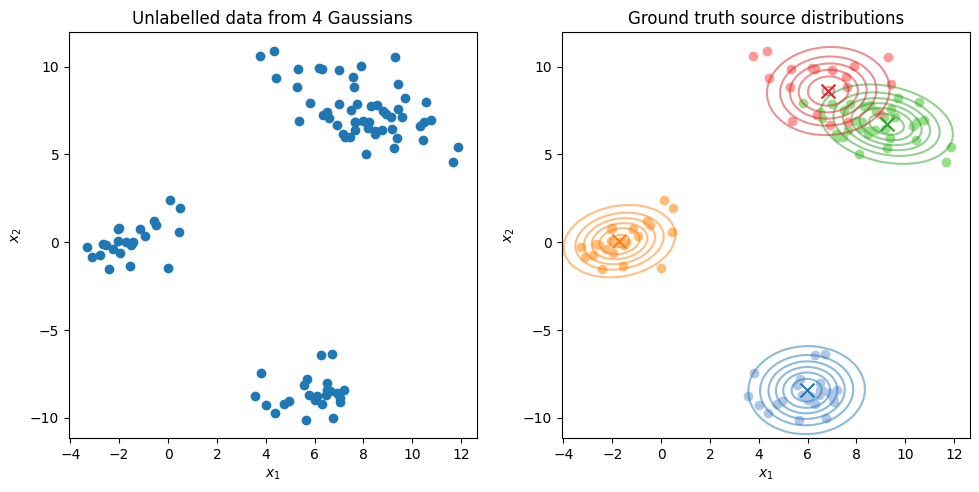

In [102]:
# randomly generate parameters for the source distributions

# means are just chosen uniformly, so may or may not be well-separated
means = [ shared_rng.random(2) * (LIMITS[1] - LIMITS[0]) + LIMITS[0] for ii in range(NUM_GAUSSIANS) ]

# covariances are also randomised, but we fudge them a bit to ensure
# positive semi-definiteness
covs = [ shared_rng.random((2,2)) * 2 - 1 for ii in range(NUM_GAUSSIANS) ]
covs = [ (np.eye(2) + cc.T @ cc) for cc in covs ]

# class membership is again fudged to even things out a bit
class_probs = shared_rng.random(NUM_GAUSSIANS) + np.ones(NUM_GAUSSIANS) * 0.5
class_probs /= np.sum(class_probs)

# generate
X, y = generate_gaussian_mix ( NUM_SAMPLES, means, covs, class_probs, shared_rng )

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(ncols=2)

if X is None:
    utils.plot_unimplemented(axs[0], title=f'Unlabelled data from {NUM_GAUSSIANS} Gaussians')
    utils.plot_unimplemented(axs[1], title=f'Ground truth source distributions')
else:
    # one plot includes all points without source attribution
    axs[0].scatter(X[:,0], X[:,1])
    axs[0].set_title(f'Unlabelled data from {NUM_GAUSSIANS} Gaussians')
    axs[0].set_xlabel('$x_1$')
    axs[0].set_ylabel('$x_2$');

    # for the other plot, we'll colour each point for its source
    for ii in range(NUM_GAUSSIANS):
        idx = (y == ii)
        axs[1].scatter(X[idx,0], X[idx,1], color=LIGHT[ii])

    # we're also going to add contours for each gaussian,
    # for which we'll need a points grid
    left, right = axs[1].get_xlim()
    bottom, top = axs[1].get_ylim()
    xx = np.linspace(left, right, 100)
    yy = np.linspace(bottom, top, 100)
    grid = np.moveaxis(np.stack(np.meshgrid(xx, yy, indexing='xy')), 0, -1)
    extent = (left, right, bottom, top)

    # draw the contours and centre points in the appropriate colours
    for ii in range(NUM_GAUSSIANS):
        pdf = mvn.pdf(grid, mean=means[ii], cov=covs[ii])
        axs[1].contour(xx, yy, pdf, origin='lower', extent=extent, alpha=0.5, colors=[DARK[ii]])
        axs[1].scatter(means[ii][0], means[ii][1], s=100, color=DARK[ii], marker='x')

    axs[1].set_title(f'Ground truth source distributions')
    axs[1].set_xlabel('$x_1$')
    axs[1].set_ylabel('$x_2$');

fig.tight_layout(pad=1)

# Task 2: Fit a Gaussian Mixture Model

Gaussian mixture models are fitted by a version of the expectation-maximisation (EM) algorithm, starting from an initial guess and iteratively maximising the likelihood of the model parameters in alternating steps.

In the **E-step**, soft assignments or **responsibilities**, $\gamma_{i,j}$, are estimated for each sample $i$ with respect to each Gaussian component $j$:

\begin{equation}
\gamma_{i,j} = \frac{\phi (\mathbf{x}_i ; \mathbf{\mu}_j, \mathbf{\Sigma}_j) \alpha_j}{\sum_t \phi (\mathbf{x}_i ; \mathbf{\mu}_t, \mathbf{\Sigma}_t) \alpha_t}
\end{equation}

The normalising factor in the denominator ensures that the responsibilities for each sample sum to 1.

In the **M-step**, the model parameters are updated from the data according to the responsibilities:

\begin{align}
\mathbf{\mu}_j &= \frac{\sum_i \gamma_{i,j} \mathbf{x}_i}{\sum_i \gamma_{i,j}} \\
\mathbf{\Sigma}_j &= \frac{\sum_i \gamma_{i,j} (\mathbf{x}_i - \mathbf{\mu}_j)(\mathbf{x}_i - \mathbf{\mu}_j)^{\mathsf{T}}}{\sum_i \gamma_{i,j}}  \\
\alpha_j &= \frac{\sum_i \gamma_{i,j}}{n}
\end{align}

Note that for these purposes the vectors should be considered as **column** vectors, so the product in the numerator of the second line above is an **outer product**, whose result is a $d \times d$ matrix.

The overall **log likelihood** of the model can be estimated as the sum of the log probabilities of all the observations given the Gaussian parameters, weighted by the class probabilities:

\begin{equation}
l(\mathbf{\theta}) = \sum_i^n \log \sum_j^k \alpha_j \phi(\mathbf{x}_i ; \mathbf{\mu}_j, \mathbf{\Sigma}_j)
\end{equation}


## 2.1 Calculate the log-likelihood of a GMM

Implement the `gaussian_mix_loglik` function in the code cell below to calculate the likelihood of the model parameters given the data — that is, $l(\mathbf{\theta})$, as given above.

Note that SciPy provides an object encapsulating the multivariate Gaussian density, [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html), which we imported at the top of this notebook as `mvn`. The method `pdf` on this object can be used to evaluate the probability of one or more data samples.

In [ ]:
def gaussian_mix_loglik ( X, means, covs, class_probs ):
    """
    Estimate the log likelihood of the given mixture model.

    # Arguments
        X: a matrix of sample inputs, where
            the samples are the rows and the
            columns are features, ie size is:
              num_samples x num_features
        means: a list of vectors specifying mean of each gaussian
            (all the same length == the number of features)
        covs: a list of covariance matrices
            (same length as means, with each matrix being
            num features x num features, symmetric and
            positive semidefinite)
        class_probs: a vector of class probabilities,
            (same length as means, all non-negative and
            summing to 1)

    # Returns
        loglik: the (scalar) log likelihood of the model
    """

    # TODO: implement this
    return None

## 2.2 Perform the E-step

Implement `gaussian_mix_E_step` in the code cell below to estimate the **responsibilities**, $\gamma_{i,j}$ — ie, the degree to which we attribute each data sample to each Gaussian component. Note that in this step we take all the distribution parameters as given.

Again, you will probably want to use [`mvn.pdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html).

In [ ]:
def gaussian_mix_E_step ( X, means, covs, class_probs ):
    """
    Given a candidate set of gaussian mix parameters,
    estimate the responsiblilites of each component for
    each data sample.

    # Arguments
        X: a matrix of sample inputs, where
            the samples are the rows and the
            columns are features, ie size is:
              num_samples x num_features
        means: a list of vectors specifying mean of each gaussian
            (all the same length == the number of features)
        covs: a list of covariance matrices
            (same length as means, with each matrix being
            num features x num features, symmetric and
            positive semidefinite)
        class_probs: a vector of class probabilities,
            (same length as means, all non-negative and
            summing to 1)

    # Returns
        resps: a matrix of weights attributing
            samples to source gaussians, of size
              num_samples x num_gaussians
    """

    # TODO: implement this
    return None

## 2.3 Perform the M-step

Implement `gaussian_mix_M_step` in the code cell below to update the GMM parameters. In this case, the *responsibilities* are taken as given.

In [ ]:
def gaussian_mix_M_step ( X, resps ):
    """
    Given a candidate set of responsibilities,
    estimate new gaussian mixture model parameters.

    # Arguments
        X: a matrix of sample inputs, where
            the samples are the rows and the
            columns are features, ie size is:
              num_samples x num_features
        resps: a matrix of weights attributing
            samples to source gaussians, of size
              num_samples x num_gaussians

    # Returns
        means: a list of vectors specifying mean of each gaussian
            (all the same length == the number of features)
        covs: a list of covariance matrices
            (same length as means, with each matrix being
            num features x num features, symmetric and
            positive semidefinite)
        class_probs: a vector of class probabilities,
            (same length as means, all non-negative and
            summing to 1)
    """
    # TODO: implement this
    return None, None, None

## 2.4 Iteratively fit the model

Implement `fit_gaussian_mix` in the code cell below to actually do the fitting.

Use the functions you implemented in Tasks 2.1–2.3 to perform the EM steps and to evaluate the likelihood. You will need to choose an appropriate set of `num_gaussians` initial values for the means, covariances and class probabilities.

In [ ]:
def fit_gaussian_mix ( X, num_gaussians, rng, max_iter=10,
                       loglik_stop=1e-1 ):
    """
    Fit a gaussian mixture model to some data.

    # Arguments
        X: a matrix of sample inputs, where
            the samples are the rows and the
            columns are features, ie size is:
              num_samples x num_features
        num_gaussians: the number of components
            to fit
        rng: an instance of numpy.random.Generator
            from which to draw random numbers
        max_iter: the maximum number of iterations
            to perform
        loglik_stop: stop iterating once the improvement
            in log likelihood drops below this

    # Returns
        resps: a matrix of weights attributing
            samples to source gaussians, of size
              num_samples x num_gaussians
        means: a list of num_gaussians vectors specifying means
        covs: a list of num_gaussians covariance matrices
        class_probs: a vector of num_gaussian class probabilities
        logliks: a list of the model log likelihood values after
            each fitting iteration
    """

    # TODO: implement this
    return None, None, None, None, None

## → Run Task 2

Run the cell below to actually fit a Gaussian Mixture Model to the data generated in Task 1, and plot the results. How does it do? Is the fit convincing? Does the dataset seem easy or hard? Does the likelihood improve consistently?

By default we fit the same number of components here as we originally generated, but in reality we might not know how many there are. Try changing `FIT_GAUSSIANS` to fit more components, or fewer. Again, how does it do?

In [ ]:
# NB: this uses the data generated and plotted in Task 1

# fitting params - you might want to play with these
FIT_GAUSSIANS = NUM_GAUSSIANS
MAX_ITER = 10

fit_resps, fit_means, fit_covs, fit_class_probs, fit_logliks = fit_gaussian_mix ( X, num_gaussians=FIT_GAUSSIANS,
                                                                                  rng=shared_rng, max_iter=MAX_ITER )

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(ncols=2)

if fit_resps is None:
    utils.plot_unimplemented(axs[0], title='Fitting History')
    utils.plot_unimplemented(axs[1], title=f'Fit to {FIT_GAUSSIANS} Gaussians')
else:
    axs[0].plot(np.arange(len(fit_logliks))+1, fit_logliks)
    axs[0].set_title('Fitting History')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Model Log Likelihood');

    y_hat = np.argmax(fit_resps, axis=1)
    for ii in range(FIT_GAUSSIANS):
        idx = (y_hat == ii)
        axs[1].scatter(X[idx,0], X[idx,1], color=LIGHT[ii])

    # we'll again add contours for each (fitted) gaussian
    left, right = axs[1].get_xlim()
    bottom, top = axs[1].get_ylim()
    xx = np.linspace(left, right, 100)
    yy = np.linspace(bottom, top, 100)
    grid = np.moveaxis(np.stack(np.meshgrid(xx, yy, indexing='xy')), 0, -1)
    extent = (left, right, bottom, top)

    # draw the contours and centre points in the appropriate colours
    for ii in range(FIT_GAUSSIANS):
        pdf = mvn.pdf(grid, mean=fit_means[ii], cov=fit_covs[ii])
        axs[1].contour(xx, yy, pdf, origin='lower', extent=extent, alpha=0.5, colors=[DARK[ii]])
        axs[1].scatter(fit_means[ii][0], fit_means[ii][1], s=100, color=DARK[ii], marker='x')

    axs[1].set_title(f'Fit to {FIT_GAUSSIANS} Gaussians')
    axs[1].set_xlabel('$x_1$')
    axs[1].set_ylabel('$x_2$');

fig.tight_layout(pad=1)


# Task 3: Generate data from a Hidden Markov Model

In a hidden Markov model, the visible output is conditioned on some unobserved **latent state** that varies over time, with the state at any discrete time step $t$, $z_t$, depending only on the state at the previous time step, $z_{t-1}$.

For these exercises we will consider only scalar observations, $x_t$, whose values are normally distributed with mean and variance according to the latent state:
\begin{equation}
(x_t | z_t = j) \sim N(\mu_j, \sigma_j^2 )
\end{equation}
So the parameters $\mu_1, \mu_2, ..., \mu_k$ and $\sigma_1, \sigma_2, ... , \sigma_k$ define the **emission probabilities**.

The transition probabilities are defined by a $k \times k$  **transition matrix** in which the element at row $i$ and column $j$ specifies the probability of going from state $i$ to state $j$, ie:

\begin{equation}
a_{i,j} = P(z_{t+1} = j | z_t = i)
\end{equation}

The distribution of starting states of the model is determined by an **initial probability** vector $\mathbf{\pi} = [\pi_1, \pi_2, ... , \pi_k]$, where

\begin{equation}
\pi_j = P(z_1 = j)
\end{equation}


## 3.1 Generate the data

Implement `generate_hmm_sequence` in the code cell below to generate data from a fully parameterised HMM.

The [choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) method of [numpy.random.Generator](https://numpy.org/doc/stable/reference/random/generator.html) is useful for drawing single values from a categorical distribution. (In contrast, the [multinomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multinomial.html) method models the outcomes of multiple trials, returning *counts* rather than single values.)

As in Task 1.1, you are asked to return the true hidden state sequence as well as the observations for plotting purposes. Obviously these would not be available for real data.

In [ ]:
def generate_hmm_sequence ( num_samples,
                            initial_probs, transitions,
                            emission_means, emission_sds,
                            rng ):
    """
    Generate a sequence of observations from a hidden Markov
    model with the given parameters. Emissions are univariate
    Gaussians.

    # Arguments
        num_samples: number of samples (ie timesteps) to generate
        initial_probs: vector of probabilities of being in each hidden
            state at time step 1; must sum to 1
        transitions: matrix of transition probabilities, from state
            indexed by row to state indexed by column; rows must sum to 1
        emission_means: mean of observations for each hidden state
        emission_sds: standard deviation of observations for each hidden state
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        x: a vector of observations for each time step
        z: a vector of hidden state (indices) for each time step
    """

    # TODO: implement this
    return None, None

## → Run Task 3

Run the cell below to generate a sequence of samples from your HMM function, plotting both the observations and the underlying states.

In [ ]:
# HMM parameters are randomised around some configuration details

# how much data to generate
NUM_TIMESTEPS = 500

# how many hidden states are there?
NUM_HIDDEN = 3

# how strong is our baseline tendency to remain in the same state
DWELL = 10

# how noisy is our emission output
NOISE = 0.2

# how uniform are our start probabilities
START_SIMILARITY = 0.1

initial_probs = shared_rng.random(NUM_HIDDEN) + START_SIMILARITY
initial_probs /= np.sum(initial_probs)

# randomise transitions with a dwell bias on the main diagonal
transitions = shared_rng.random((NUM_HIDDEN, NUM_HIDDEN)) + np.eye(NUM_HIDDEN) * DWELL

# scale each row to sum to 1
for ii in range(NUM_HIDDEN):
    transitions[ii,:] /= np.sum(transitions[ii,:])

# means are just evenly spaced for simplicity
# (mainly this makes the plotting nice and easy)
emission_means = np.arange(NUM_HIDDEN)

# variances are randomised
emission_sds = shared_rng.random(NUM_HIDDEN) * NOISE

x, z = generate_hmm_sequence( NUM_TIMESTEPS, initial_probs, transitions,
                              emission_means, emission_sds, shared_rng )

fig = plt.figure(figsize=(6,6))
ax = fig.subplots()

ax.plot(x, color=DARK[1], label='Observed')
ax.plot(z, color=DARK[0], label='Hidden')
ax.set_title(f'Hidden Markov Model')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='upper right')

fig.tight_layout(pad=1)

# Task 4: Decode the underlying state sequence using the Viterbi algorithm

The Viterbi algorithm iterates forwards through the sequence, at each timestep $t$ estimating the highest probability of being in each state, given these factors:

* the present observation $x_t$
* the probability of transition to $z_t$ from each previous state $z_{t-1} = j$
* the previously estimated probability of being in that previous state, $\alpha_{t-1}(j)$

The recurrence relation looks like this:

\begin{equation}
\alpha_t(j) = \max_i \; \alpha_{t-1}(i) \, a_{i,j} \, P(x_t ; \mu_j, \sigma_j)
\end{equation}

For each state at each step it also records which previous state produced that highest probability as a **backpointer**, $\zeta_t(j)$:

\begin{equation}
\zeta_t(j) = \text{argmax}_i \; \alpha_{t-1}(i) \, a_{i,j} \, P(x_t ; \mu_j, \sigma_j)
\end{equation}

At the end of the sequence, timestep $T$, the most likely final state is identified:

\begin{equation}
z_T = \text{argmax}_j \alpha_T(j)
\end{equation}

and the $\zeta_t$ are traced backwards to reconstruct the complete most likely sequence:
\begin{equation}
z_{t-1} = \zeta_t(z_t)
\end{equation}


## 4.1 Find the most likely hidden state sequence

Implement the `viterbi` function in the cell below to infer a hidden state sequence from observations using the algorithm described above. Note that this algorithm only infers the states — it assumes the HMM parameters are already known.

Although the calculations as given above are not enormously complicated, this can be a bit fiddly to implement. You will need to build a $k \times T$ "trellis" matrix for both the $\alpha$ and $\zeta$ values. As with long chains of gradients in backpropagation, the probability products here can get vanishingly small and make things numerically unstable, so it's probably a good idea to normalise at each timestep.

The SciPy method [scipy.stats.norm.pdf](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) evaluates the univariate Gaussian density. As with `mvn`, we imported the class back at the start, so you can invoke it as just `norm.pdf(...)`.

In [ ]:
def viterbi ( x, initial_probs, transitions, emission_means, emission_sds ):
    """
    Infer the most likely sequence of hidden states based on
    observations and HMM parameters.

    # Arguments
        x: a vector of observations for each time step
        initial_probs: vector of probabilities of being in each hidden
            state at time step 1; must sum to 1
        transitions: matrix of transition probabilities, from state
            indexed by row to state indexed by column; rows must sum to 1
        emission_means: mean of observations for each hidden state
        emission_sds: standard deviation of observations for each hidden state

    # Returns
        z: a vector of predicted hidden state (indices) for each time step
    """

    # TODO: implement this
    return None

## → Run Task 4

Run the cell below to infer the hidden states from the observations using your Viterbi implementation above.

As a point of comparison, the test code also employs the  [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) package to infer the hidden states — but without any knowledge of the underlying HMM parameters (other than the number of states). So it must first infer those parameters before decoding the sequence. This is a *significantly* harder task than Viterbi alone, so the resulting fit will almost certainly be much worse than yours.

As ever, play around with the parameters governing both the data generation and the fitting to see what effects they have.

In [ ]:
fit_z = viterbi ( x, initial_probs, transitions, emission_means, emission_sds )

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(ncols=2)

if fit_z is None:
    utils.plot_unimplemented(axs[0], title=f'Viterbi Decoding (True Model)')
else:
    axs[0].plot(z, color=DARK[1], label='True')
    axs[0].plot(fit_z, color=DARK[0], label='Decoded')
    axs[0].set_title(f'Viterbi Decoding (True Model)')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('State')
    axs[0].legend(loc='upper right')

# infer model params using hmmlearn
hmg = hmm.GaussianHMM(NUM_HIDDEN)
hmg.fit(x.reshape(-1,1))
hfit_z = hmg.predict(x.reshape(-1,1))

axs[1].plot(z, color=DARK[1], label='True')
axs[1].plot(hfit_z.ravel(), color=DARK[0], label='Decoded')
axs[1].set_title(f'Viterbi Decoding (Fitted Model)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('State')
axs[1].legend(loc='upper right')

fig.tight_layout(pad=1)

# Further exploration

If you're feeling adventurous, you could try implementing the [Baum-Welch algorithm](https://en.wikipedia.org/wiki/Baum–Welch_algorithm) to fit the model parameters. This is the actual expectation-maximisation procedure that `hmmlearn` is doing behind the scenes. Needless to say, it is significantly more fiddly than Viterbi.
